# Life Expectancy Analysis: Developed vs. Developing Countries

## Research Question

Is there a statistically significant difference in life expectancy between developed and developing countries?

This project explores that question using a combination of SQL queries and statistical analysis in Python.



## Methodology

- **Dataset**: Public dataset containing health and development indicators for countries from 2000 to 2015.
- **Tools Used**: DuckDB (SQL), pandas, seaborn, scipy
- **Steps**:
  1. Queried life expectancy values using SQL based on development status
  2. Explored distributional characteristics (mean, standard deviation, skewness, kurtosis)
  3. Visualized life expectancy distributions with histograms
  4. Assessed normality with Kolmogorov-Smirnov and Shapiro-Wilk tests
  5. Checked variance equality using Levene's test
  6. Compared groups using the Mann-Whitney U test due to non-normality
  7. Calculated effect size (rank-biserial correlation)


In [51]:
# First, let's get a feel of the data
import duckdb
duckdb.sql('SELECT * FROM "Life Expectancy Data.csv" LIMIT 20').df()


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,...,6,8.16,65,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,...,58,8.18,62,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,...,62,8.13,64,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,...,67,8.52,67,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,...,68,7.87,68,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,...,66,9.20,66,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281,77,0.01,56.762217,63,2861,...,63,9.42,63,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287,80,0.03,25.873925,64,1599,...,64,8.33,64,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295,82,0.02,10.910156,63,1141,...,63,6.73,63,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295,84,0.03,17.171518,64,1990,...,58,7.43,58,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [54]:
# Let's explore descriptives and get a sense of the data's shape
duckdb.sql("""
    SELECT
        Status,
        COUNT(*) AS num_entries,
        AVG("Life expectancy") AS mean_life_expectancy,
        STDDEV("Life expectancy") AS std_life_expectancy,
        MIN("Life expectancy") AS min_life_expectancy,
        MAX("Life expectancy") AS max_life_expectancy,
        SKEWNESS("Life expectancy") AS skew_life_expectancy,
        KURTOSIS("Life expectancy") AS kurtosis_life_expectancy
    FROM "Life Expectancy Data.csv"
    WHERE "Life expectancy" IS NOT NULL
    GROUP BY Status
""").df()


,Status,num_entries,mean_life_expectancy,std_life_expectancy,min_life_expectancy,max_life_expectancy,skew_life_expectancy,kurtosis_life_expectancy
0,Developing,2416,67.111465,9.006092,36.3,89.0,-0.621716,-0.370722
1,Developed,512,79.197852,3.930942,69.9,89.0,0.094832,-0.118818


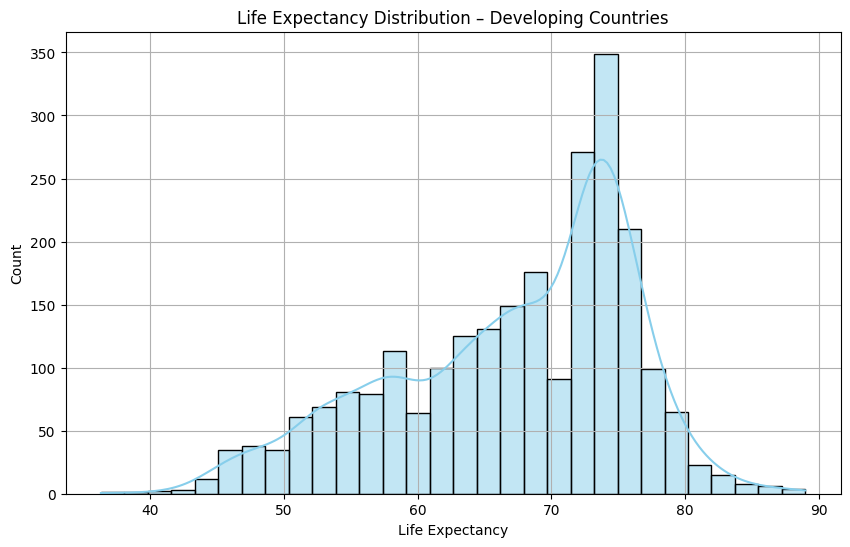

In [58]:
# Even though we have skenwess and kurtosis values, it is best practice to visualize the distributions of e
import pandas as pd
from scipy import stats

plt.figure(figsize=(10, 6))
sns.histplot(data=df_dev, x="Life expectancy", bins=30, kde=True, color="skyblue")
plt.title("Life Expectancy Distribution – Developing Countries")
plt.xlabel("Life Expectancy")
plt.ylabel("Count")
plt.grid(True)
plt.show()


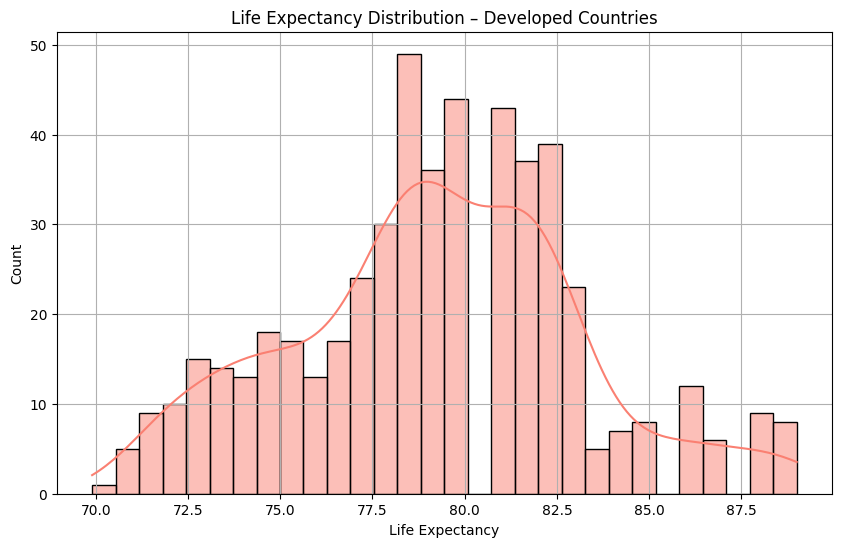

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_developed, x="Life expectancy", bins=30, kde=True, color="salmon")
plt.title("Life Expectancy Distribution – Developed Countries")
plt.xlabel("Life Expectancy")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [63]:
# To get better insight, let's run tests to see if each group's distribution significantly deviates from normality. I will also check if variance is equal between groups.

developed = df[df["Status"] == "Developed"]["Life expectancy"]
developing = df[df["Status"] == "Developing"]["Life expectancy"]


ks_dev = stats.kstest(developed, 'norm', args=(developed.mean(), developed.std()))
ks_devg = stats.kstest(developing, 'norm', args=(developing.mean(), developing.std()))

shapiro_dev = stats.shapiro(developed)
shapiro_devg = stats.shapiro(developing)

levene_stat, levene_p = stats.levene(developed, developing)


summary_df = pd.DataFrame({
    "Test": [
        "Kolmogorov-Smirnov",
        "Kolmogorov-Smirnov",
        "Shapiro-Wilk",
        "Shapiro-Wilk",
        "Levene's Test"
    ],
    "Group": [
        "Developed",
        "Developing",
        "Developed",
        "Developing",
        "Both Groups"
    ],
    "Statistic": [
        round(ks_dev.statistic, 3),
        round(ks_devg.statistic, 3),
        round(shapiro_dev.statistic, 3),
        round(shapiro_devg.statistic, 3),
        round(levene_stat, 3)
    ],
    "p-value": [
        f"{ks_dev.pvalue:.3e}",
        f"{ks_devg.pvalue:.3e}",
        f"{shapiro_dev.pvalue:.3e}",
        f"{shapiro_devg.pvalue:.3e}",
        f"{levene_p:.3e}"
    ]
})

from IPython.display import display
display(summary_df)


,Test,Group,Statistic,p-value
0,Kolmogorov-Smirnov,Developed,0.061,4.010e-02
1,Kolmogorov-Smirnov,Developing,0.126,6.263e-34
2,Shapiro-Wilk,Developed,0.984,2.671e-05
3,Shapiro-Wilk,Developing,0.950,5.876e-28
4,Levene's Test,Both Groups,286.262,2.438e-61


In [46]:
# Given that both groups statisically differ from a normal distribution and variance is unequal, the nonparametric Mann-Whitney U test is most appropriate

from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

# Group variables
developed = df[df["Status"] == "Developed"]["Life expectancy"]
developing = df[df["Status"] == "Developing"]["Life expectancy"]

# Mann–Whitney U Test (Wilcoxon rank-sum for independent samples)
u_stat, p_val = mannwhitneyu(developed, developing, alternative='two-sided')

# Rank-biserial correlation: (R1 - R2) / (n1 * n2)
n1 = len(developed)
n2 = len(developing)
u_max = n1 * n2
rank_biserial = 1 - (2 * u_stat / u_max)

# Format p-value
def pval_notation(p):
    return "p < .001" if p < 0.001 else f"p = {p:.3f}"

# Create summary table
mw_summary = pd.DataFrame({
    "Test": ["Mann–Whitney U", "Rank-Biserial Correlation"],
    "Statistic": [round(u_stat, 2), round(rank_biserial, 3)],
    "p-value": [f"{p_val:.3e}", "–"],
    "p-value (notation)": [pval_notation(p_val), "–"]
})

mw_summary


,Test,Statistic,p-value,p-value (notation)
0,Mann–Whitney U,1131521.000,1.371e-191,p < .001
1,Rank-Biserial Correlation,-0.829,–,–


/var/folders/rj/wxl7l5k53b1fyj5px1_t8fsr0000gn/T/ipykernel_6564/4102486707.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Status", y="Life expectancy", data=df, palette="Set2")


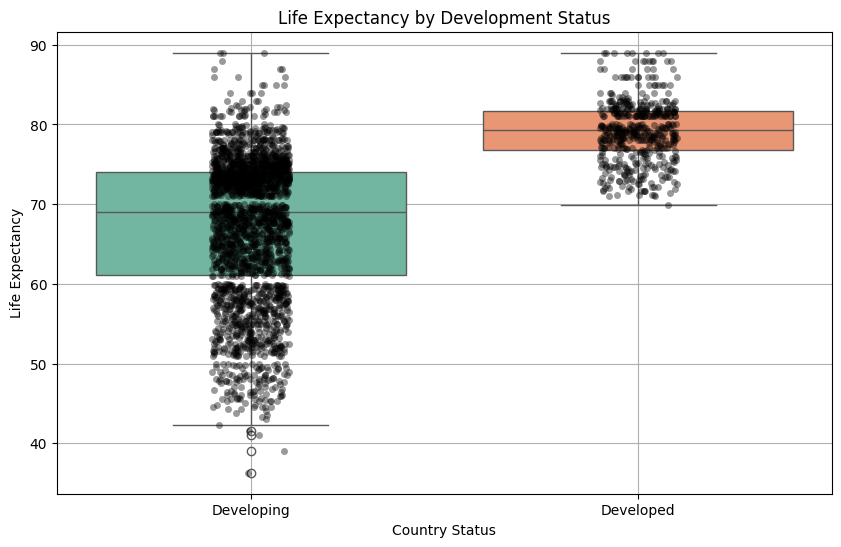

In [57]:
# Developed and Developing countries do statistically differ in life expectancy. The effect size is large, and I can use a boxplot to showcase this
plt.figure(figsize=(10, 6))
sns.boxplot(x="Status", y="Life expectancy", data=df, palette="Set2")
sns.stripplot(x="Status", y="Life expectancy", data=df, color="black", alpha=0.4, jitter=True)
plt.title("Life Expectancy by Development Status")
plt.ylabel("Life Expectancy")
plt.xlabel("Country Status")
plt.grid(True)
plt.show()


## Conclusion

This analysis found a significant and substantial difference in life expectancy between developed and developing countries (p<.001). 

While this project was limited to exploratory statistical analysis, it highlights how public health outcomes vary across economic contexts and shows how SQL and Python can be used together for real-world data science projects.

> For more, check out the SQL queries, visualizations, and statistical tests in the cells above.
